In [ ]:
import numpy
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import sys
sys.path.append('../')
from utils import image_processing

In [ ]:
data_path = "C:/Users/wjtay/Documents/GitHub/CS701/public/train_label.txt"
img_dir = "C:/Users/wjtay/Documents/GitHub/CS701/public/img_dir/train/"

In [ ]:
by_name = {}
by_label = {k: [] for k in range(104)}
for line in open(data_path):
    parts = line.strip().split(' ')
    name = parts[0].split('.')[0] + '.jpg'
    labels = [int(x) for x in parts[1:]]
    by_name.update({name: labels})

    for label in labels:
        by_label.get(label).append(name)
 

In [ ]:
keys = sorted(by_label, key=lambda k: len(by_label[k]), reverse=True)
values = [len(by_label[k]) for  k in keys]
ax = sns.barplot(x=keys, y=values, order=keys)
plt.title('Distribution of all label counts')
plt.show()

In [ ]:
ax = sns.barplot(x=keys[:10], y=values[:10], order=keys[:10])
plt.title('Distribution of top 10 label counts')
plt.show()

ax = sns.barplot(x=keys[-10:], y=values[-10:], order=keys[-10:])
plt.title('Distribution of smallest 10 label counts')
plt.show()

In [ ]:
## Coocurence matrix
occ = list(by_name.values())
df = pd.DataFrame(occ).stack().rename('val').reset_index().drop(columns='level_1')

df = df.merge(df, on='level_0').query('val_x != val_y')
coocur = pd.crosstab(df.val_x, df.val_y)

sns.heatmap(coocur)
plt.title('Co-occurence matrix')
plt.show()

In [ ]:
from collections import Counter
lengths = [len(by_name[k]) for k in list(by_name.keys())]
counts = Counter(lengths)

ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Distribution of number of labels per image')
plt.show()

# Probably not very useful

In [ ]:
from tensorflow.keras.preprocessing import image

train_imgs = [fn for fn in os.listdir(img_dir) if fn.endswith('.jpg')]
select_norm = np.random.choice(train_imgs, 6, replace = False)
fig = plt.figure(figsize = (8,6))

for i in range(6):
    
    fp = f'{img_dir}{select_norm[i]}'
    label = by_name.get(select_norm[i])

    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

In [60]:
size_images = dict()
size_occur = dict()

for dirpath, _, filenames in os.walk(img_dir):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, height = img.size
            size_images.update({path_image: {'width': width, 'height': height}})

            if(size_occur.get((width,height)) == None):
                size_occur.update({(width,height) : 1})
            else:
                size_occur.update({(width, height): size_occur.get((width, height)) + 1})

print(len(size_occur))




799


In [26]:
size_occur[(512, 384)]

995

[(512, 384), (256, 256), (3264, 2448), (512, 341), (410, 273), (642, 428), (410, 307), (640, 428), (307, 204), (512, 340)]


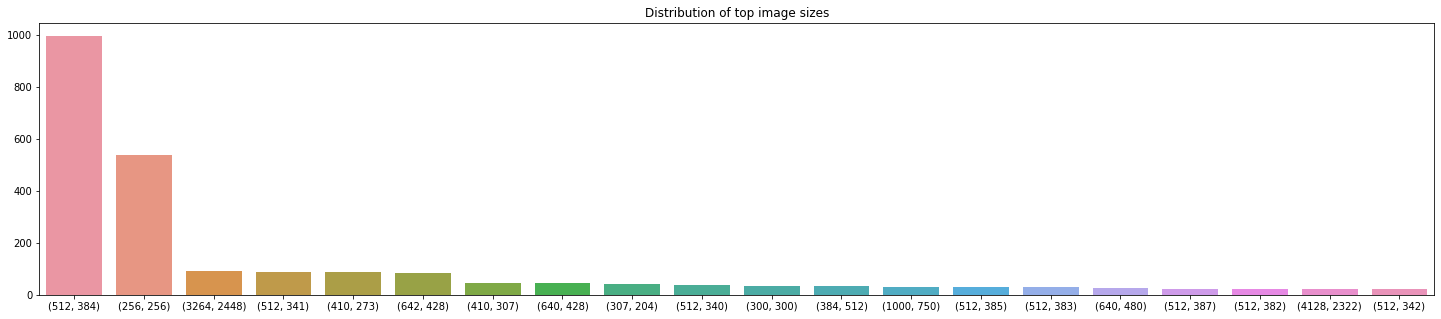

In [52]:
keys = sorted(size_occur, key=lambda k: size_occur[k], reverse=True)
x_axis = [str(v) for v in keys]
print(keys[:10])
values = [size_occur[k] for k in keys]
# print(values)
plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_axis[:20], y=values[:20])
plt.title('Distribution of top image sizes')

plt.show()

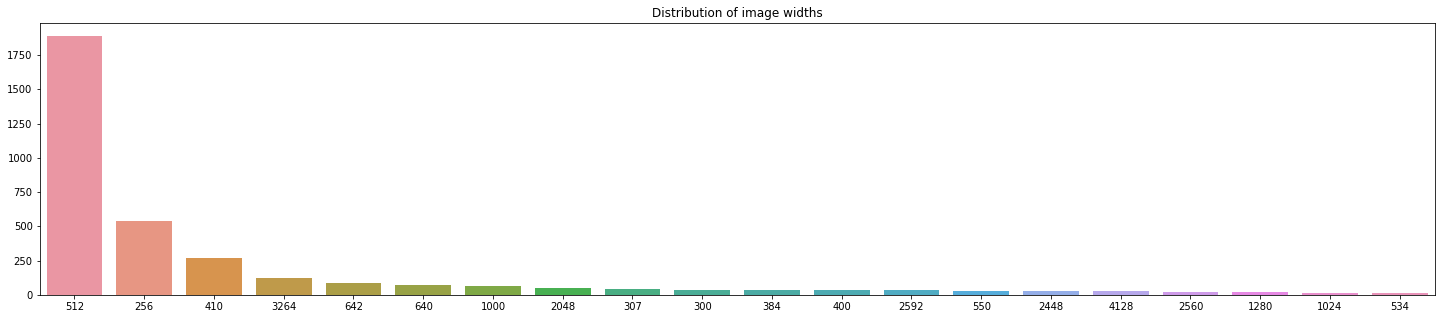

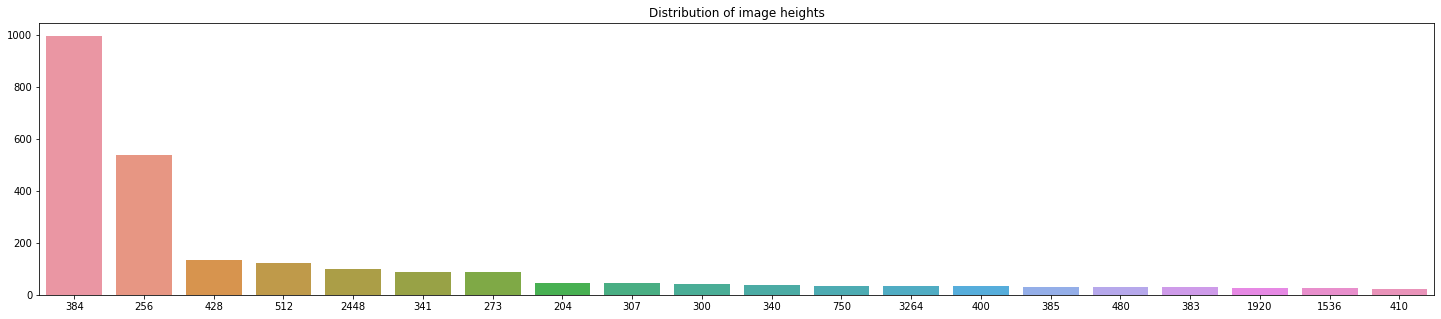

In [78]:
# widths = [size_occur[k]['width'] for k in size_occur.keys()]
widths = [size_images[k]['width'] for k in size_images.keys()]
widths_count = Counter(widths).most_common(20)
x_widths_count = list(list(zip(*widths_count))[0])
y_widths_count = list(list(zip(*widths_count))[1])

heights = [size_images[k]['height'] for k in size_images.keys()]
heights_count = Counter(heights).most_common(20)
x_heights_count = list(list(zip(*heights_count))[0])
y_heights_count = list(list(zip(*heights_count))[1])

plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_widths_count, y=y_widths_count, order=x_widths_count)
plt.title('Distribution of image widths')
plt.show()

plt.figure(figsize=(25,5))
ax = sns.barplot(x=x_heights_count, y=y_heights_count, order=x_heights_count)
plt.title('Distribution of image heights')
plt.show()

In [ ]:
# image = image_processing.read_image(img_dir + list(by_name.keys())[0])
image = image_processing.read_image(img_dir + '00000000.jpg')
print(np.array(image))

## Still working on more analysis

### Possible Augmentation

Brighten/Lighten the image